 # <div align="center">Machine Learning Workflow for House Prices</div>
---------------------------------------------------------------------
<img src="https://cdn-images-1.medium.com/max/1200/0*SbLLq8PDBbxkMO6X.png" />

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan/Final_Project_DS_Python)


 <a id="top"></a> <br>
## Notebook  Content
1. [Machine learning workflow](#1)

1. [Problem Definition](#2)

1. [Used Packages](#3)

1. [Used functions](#4)

1. [Exploratory data analysis](#5)
    1. [Data Collection](#51)
    1. [Visualization](#52)
    1. [Target Value Analysis](#53)
        1. [Skewness vs Kurtosis](#531)
1. [Data Preprocessing](#6)
    1. [Noise filtering (Outliers)](#61)
        1. [IQR method](#611)
    1. [Data Cleaning](#62)
    1. [Creating Dummy Variables](#63)
1. [Model Deployment](#7)
    1. [Validation Function](#71)
    1. [Model selection](#72)
    1. [Averaging Models](#73)

<a id="1"></a> <br>
# 1. Machine Learning Workflow

1. Define Problem
1. Data Collection
1. Data Preprocessing
1. Data Cleaning
1. Exploratory data analysis
1. Visualization
1. Model Design, Training, and Offline Evaluation
1. Model Deployment, Online Evaluation, and Monitoring
1. Model Maintenance, Diagnosis, and Retraining

Of course, the same solution can not be provided for all problems, so the best way is to create a **general framework** and adapt it to new problem.

**You can see my workflow in the below image** :

 <img src="http://s8.picofile.com/file/8344100018/workflow3.png" />

**Data Science has so many techniques and procedures that can confuse anyone.**


<a id="2"></a> <br>
# 2. Define Problem

I will use house prices data set. This data set contains information about house prices and the target value is:

    SalePrice

##  Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)
<img src='https://i.stack.imgur.com/eG03B.png' height= 200 width=350>

## Aim
It is our job to predict the sales price for each house. for each Id in the test set, you must predict the value of the **SalePrice** variable. 

[go to top](#top)

<a id="3"></a> <br>
# 3. Used packages

[go to top](#top)

In [72]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

#for timestamp column
from datetime import date

# matplotlib and seaborn for plotting
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# hide warnings
import warnings
def ignore_warn(*args, **kwargs): pass
warnings.warn = ignore_warn

# machine learining
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import train_test_split, cross_val_score , KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Statistics
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# Mathematics
from math import log

# Pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns',500 )
pd.set_option('display.max_rows',100 )
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
# pd.reset_option("display.max_rows")

<a id="4"></a> <br>
# 4. Used functions

[go to top](#top)

In [73]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    
    Parameters
    ----------
    df : dataframe
        the outliers will be checked on the df dataframe
    n : int
        threshold for number of outliers
    features : np.array
        the list of feautures for which outlier detection will be running
    
    Returns
    -------
    multiple_outliers : dataframe 
        Initial dataframe without any outliers
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [74]:
def missing_values_table(df):
    """
    Takes a dataframe df of features and returns a dataframe of the missing values (feautures).
    
    Parameters
    ----------
    df : dataframe
        The percentage of missing values will be counted for given dataframe
    
    Returns
    -------
    mis_val_table_ren_columns : dataframe 
        Return the dataframe with missing information
    """
    
    # Total missing values
    mis_val = df.isnull().sum()    
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [75]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Parameters
    ----------
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df


<a id="5"></a> <br>
# 5. Exploratory Data Analysis(EDA)
 In this section, you'll learn how to use graphical and numerical techniques to begin uncovering the structure of your data. 
 
1. Which variables suggest interesting relationships?
1. Which observations are unusual?

By the end of the section, you'll be able to answer these questions and more, while generating graphics that are both insightful and beautiful.  then We will review analytical and statistical operations:


[go to top](#top)

<a id="51"></a> <br>
## 5.1. Data Collection
**Data collection** is the process of gathering and measuring data, information or any variables of interest in a standardized and established manner that enables the collector to answer or test hypothesis and evaluate outcomes of the particular collection.[techopedia]


> **<< Note >>**

> **The rows being the samples and the columns being attributes**


In [76]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_ID = train['Id']
test_ID = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

<a id="52"></a> <br>
## 5.2 Visualization

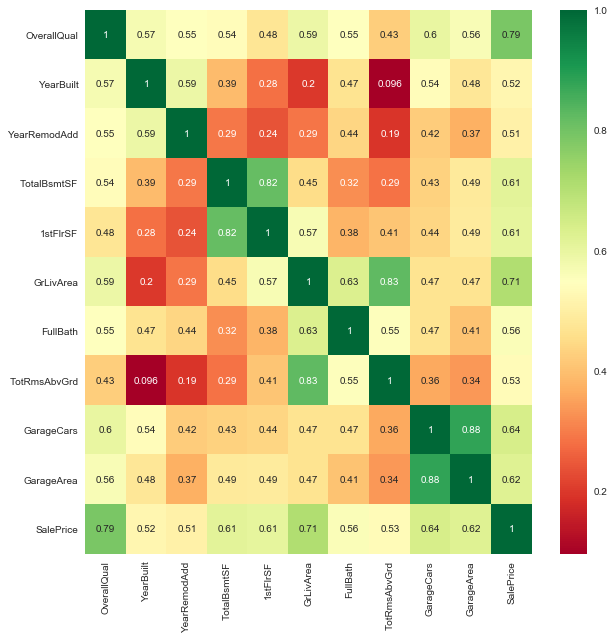

In [77]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [78]:
# corrmat.index[abs(corrmat["SalePrice"])>0.5].values

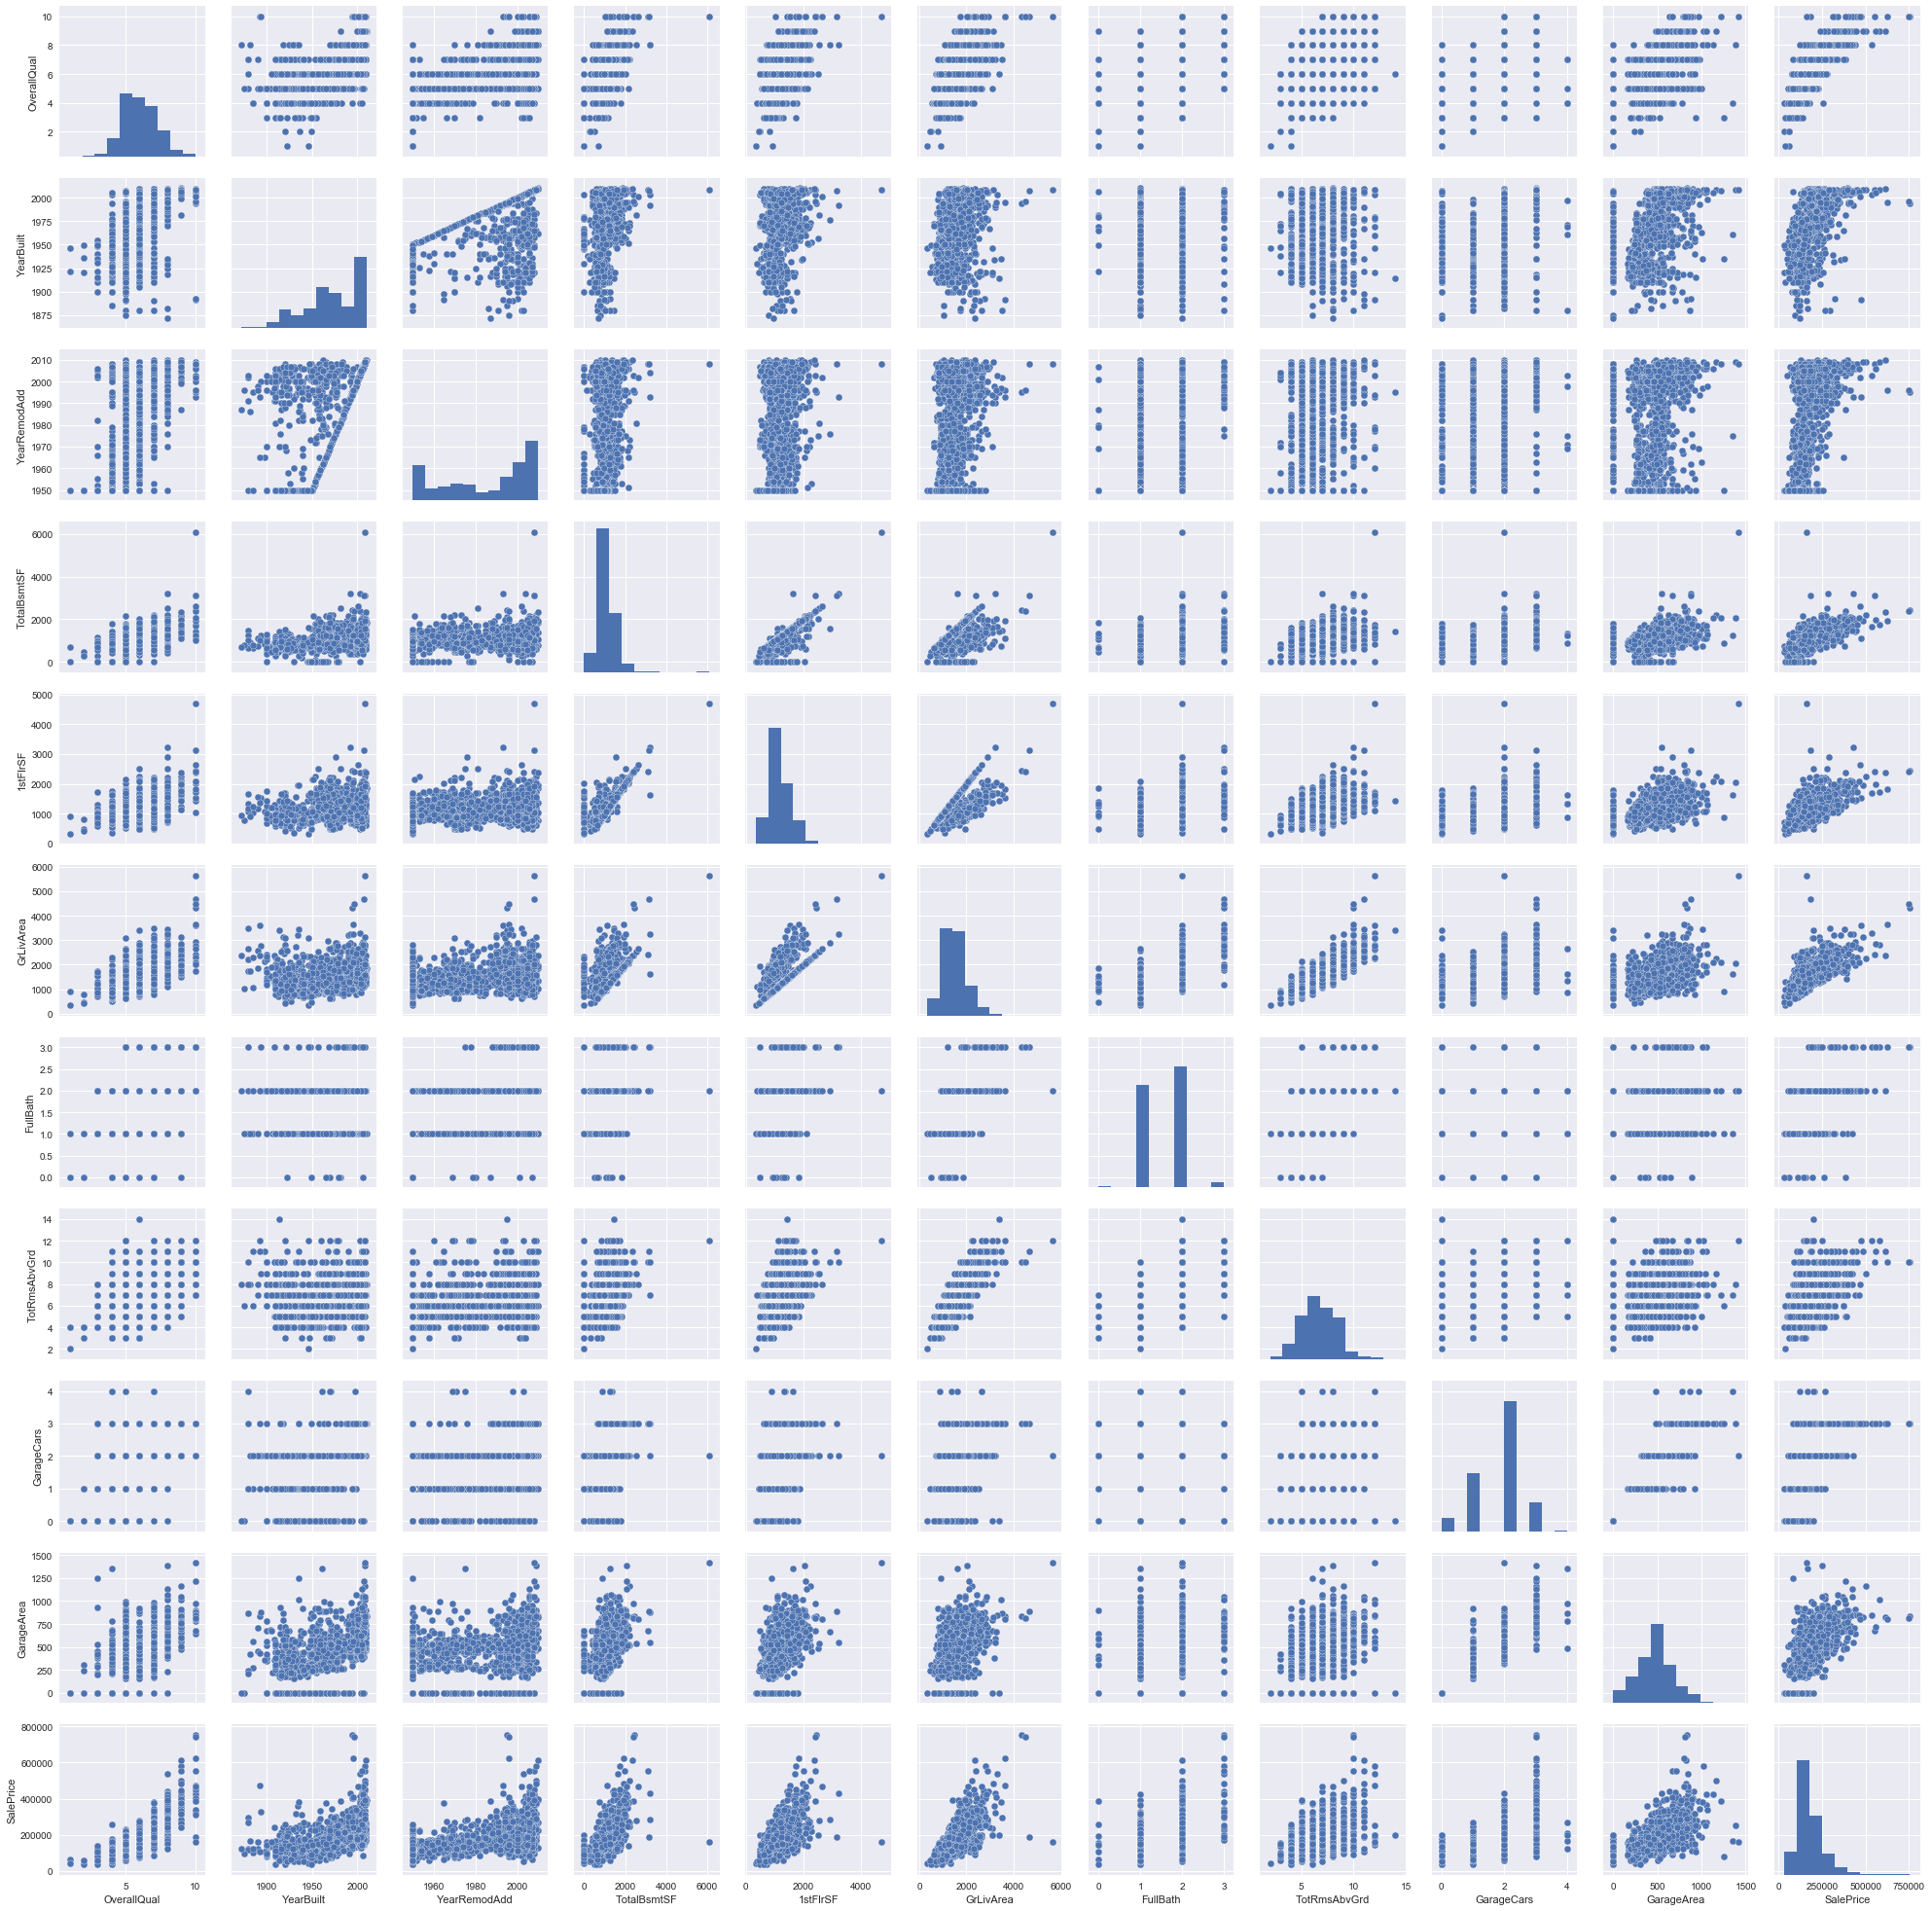

In [79]:
sns.set()
cols = corrmat.index[abs(corrmat["SalePrice"])>0.5].values
sns.pairplot(train[cols], size = 2.5)
plt.show();

<a id="53"></a> <br>
## 5.3. Target Value Analysis
As you know **SalePrice** is our target value that we should predict it then now we take a look at it

In [80]:
train['SalePrice'].describe() 

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

In [81]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


<a id="531"></a> <br>
### 5.3.1  Skewness vs Kurtosis
1. Skewness
    1. It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution. It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0.
<img src='https://www.parsmodir.com/db/statistic/skewness.png'>
1. Kurtosis
    1. Kurtosis is all about the tails of the distribution — not the peakedness or flatness. It is used to describe the extreme values in one versus the other tail. It is actually the measure of outliers present in the distribution.



 mu = 180921.20 and sigma = 79415.29



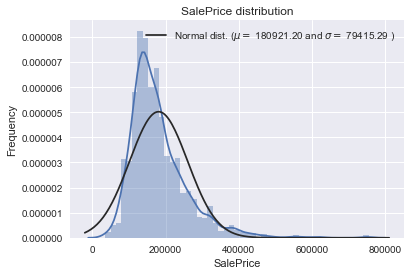

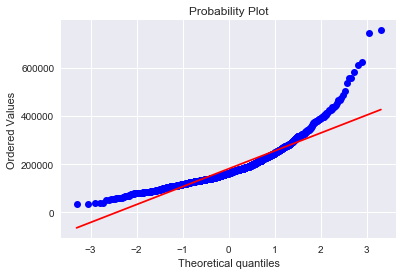

In [82]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



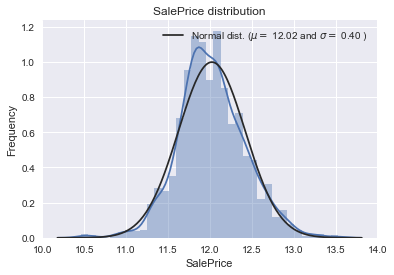

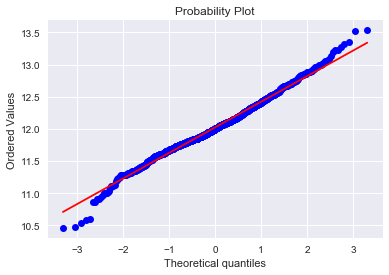

In [83]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [84]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 0.121347
Kurtosis: 0.809519


<a id="6"></a> <br>
# 6. Data Preprocessing
**Data preprocessing** refers to the transformations applied to our data before feeding it to the algorithm.
 
Data Preprocessing is a technique that is used to convert the raw data into a clean data set. In other words, whenever the data is gathered from different sources it is collected in raw format which is not feasible for the analysis.

[go to top](#top)

<a id="61"></a> <br>
## 6.1. Noise filtering (Outliers)
An outlier is a data point that is distant from other similar points. Further simplifying an outlier is an observation that lies on abnormal observation amongst the normal observations in a sample set of population.
<img src='https://cdn-images-1.medium.com/max/800/1*TbUF_HTQ6jOhO8EoPnmekQ.jpeg' height=400 width=400>
In statistics, an outlier is an observation point that is distant from other observations.


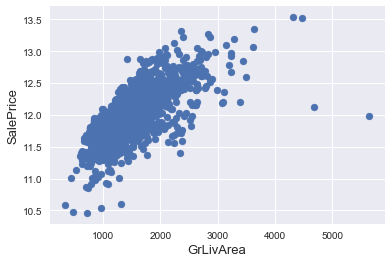

In [85]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [86]:
# #Deleting outliers
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# #Check the graphic again
# fig, ax = plt.subplots()
# ax.scatter(train['GrLivArea'], train['SalePrice'])
# plt.ylabel('SalePrice', fontsize=13)
# plt.xlabel('GrLivArea', fontsize=13)
# plt.show()

<a id="611"></a> <br>
## 6.1.1 IQR method

One of the robust methods for labeling outliers is the IQR (interquartile range) method of outlier detection developed by **John Tukey**, the pioneer of exploratory data analysis. This was in the days of calculation and plotting by hand, so the datasets involved were typically small, and the emphasis was on understanding the story the data told. If you’ve seen a box-and-whisker plot (also a Tukey contribution), you’ve seen this method in action.1

A box-and-whisker plot uses quartiles (points that divide the data into four groups of equal size) to plot the shape of the data. The box represents the 1st and 3rd quartiles, which are equal to the 25th and 75th percentiles. The line inside the box represents the 2nd quartile, which is the median.

The interquartile range, which gives this method of outlier detection its name, is the range between the first and the third quartiles (the edges of the box). Tukey considered any data point that fell outside of either 1.5 times the IQR below the first – or 1.5 times the IQR above the third – quartile to be “outside” or “far out”. In a classic box-and-whisker plot, the ‘whiskers’ extend up to the last data point that is not “outside”.

<img src='BoxPlot2.png' height=1000 width=1000>

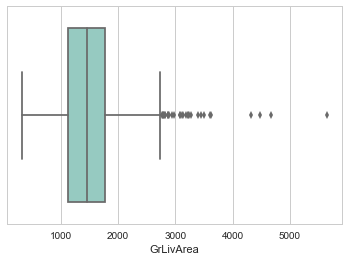

In [87]:
sns.set(style="whitegrid")
ax = sns.boxplot( x="GrLivArea", data=train, palette="Set3")

In [90]:
Outliers_to_drop = detect_outliers(train,0, corrmat.index[abs(corrmat["SalePrice"])>0.5].values)
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

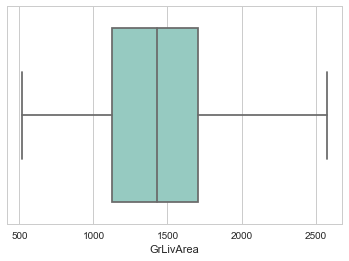

In [91]:
sns.set(style="whitegrid")
ax = sns.boxplot( x="GrLivArea", data=train, palette="Set3")

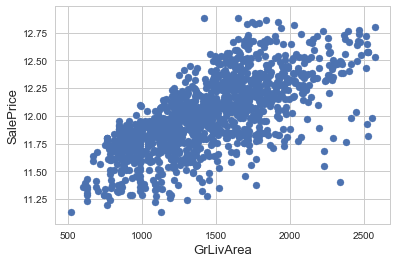

In [92]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

<a id="62"></a> <br>
## 6.2. Data Cleaning

In [93]:
ntrain = train.shape[0]
ntest = test.shape[0]

## label
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2743, 79)


In [94]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.781
MiscFeature,96.464
Alley,93.219
Fence,80.168
FireplaceQu,49.471
LotFrontage,16.879
GarageQual,5.104
GarageCond,5.104
GarageFinish,5.104
GarageYrBlt,5.104


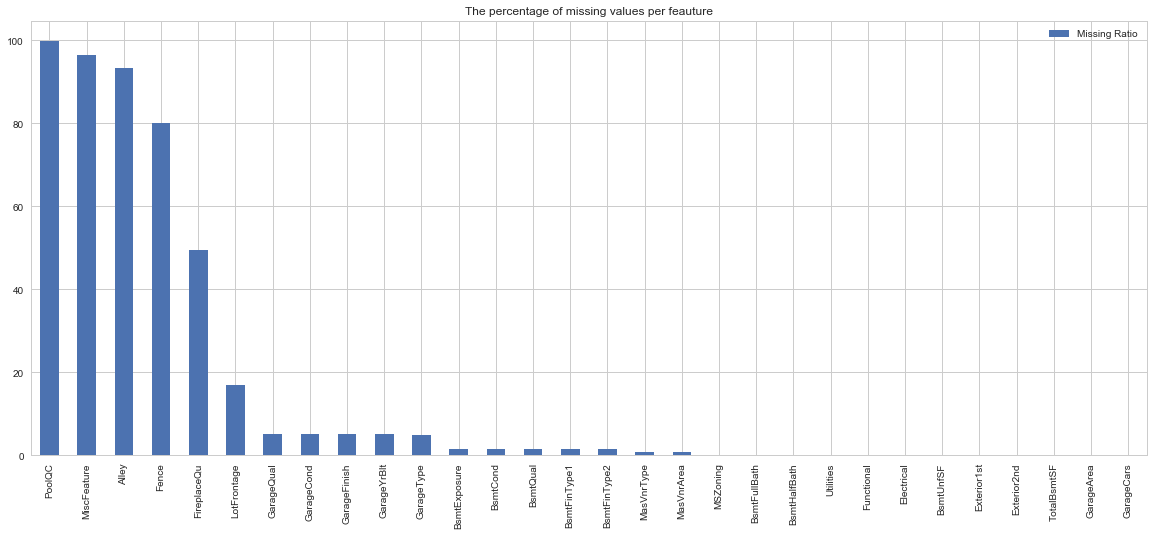

In [95]:
missing_data.plot(kind="bar", figsize=(20,8) , grid=True , title="The percentage of missing values per feauture")

In [96]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio


In [98]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2743, 79)


<a id="63"></a> <br>
## 6.3. Creating dummy variables

In [99]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2743, 334)


In [100]:
train = all_data[:ntrain]
test = all_data[ntrain:]

<a id="7"></a> <br>
# 7. Model Deployment

[go to top](#top)

<a id="71"></a> <br>
## 7.1. Validation Function

In [101]:
#Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

<a id="72"></a> <br>
## 7.2. Model selection

In [103]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [104]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [105]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [106]:
GBoost = GradientBoostingRegressor()

In [107]:
model_xgb = xgb.XGBRegressor()

In [108]:
model_lgb = lgb.LGBMRegressor(objective='regression')

In [109]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0999 (0.0066)



In [110]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0999 (0.0067)



In [111]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 1.3413 (2.0092)



In [112]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1109 (0.0058)



In [113]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1117 (0.0078)



In [114]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1122 (0.0071)



In [102]:
# # Number of trees in random forest
# n_estimators = [100, 200]
# learning_rate = [0.01, 0.05, 0.1]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [10, 20]
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 20, 40, 60]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4, 8, 16]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_boost = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                 'learning_rate' : learning_rate,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf
#                }

# # random_grid = {"max_depth": [3, None],
# #               "max_features": sp_randint(1, 11),
# #               "min_samples_split": sp_randint(2, 11),
# #               "min_samples_leaf": sp_randint(1, 11),
# #               "bootstrap": [True, False]
# #               }

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# boost = GradientBoostingRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# boost_random = RandomizedSearchCV(estimator = boost, param_distributions = random_boost, n_iter = 20, cv = 5, verbose=100, random_state=42, scoring='r2', n_jobs=1)
# # Fit the random search model
# # boost_random.fit(train, y_train)

<a id="73"></a> <br>
## 7.3. Averaging Models

In [117]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [119]:
averaged_models = AveragingModels(models = (lasso, ENet, KRR, GBoost, model_xgb, model_lgb))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.2735 (0.3154)



In [120]:
averaged_models = AveragingModels(models = (lasso, ENet, GBoost))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.0988 (0.0069)



In [121]:
GBoost.fit(train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

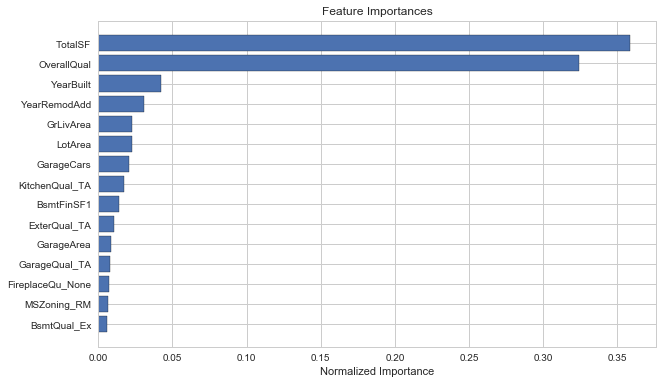

In [122]:
features = list(train.columns)
feature_importance_values = GBoost.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances)